In [24]:
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib
import io

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


In [25]:
data = pathlib.Path('training/light/')
len(list(data.glob('*/*.jpg')))

17

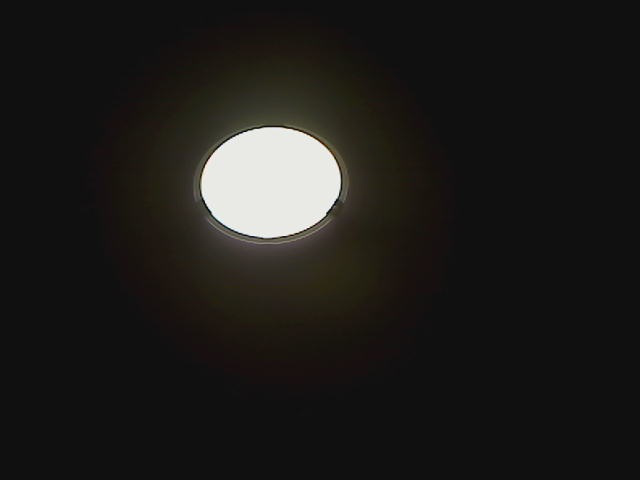

In [26]:
first_img = PIL.Image.open(next(data.glob('*/*.jpg')))
image_size = first_img.size
first_img

In [27]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data,
#   validation_split=0.15,
  seed=123,
  image_size=(image_size[1], image_size[0]),
#   subset="training"
)
# val_ds = tf.keras.preprocessing.image_dataset_from_directory(
#   data,
#   validation_split=0.15,
#   seed=123,
#   image_size=(image_size[1], image_size[0]),
#   subset="validation")

Found 17 files belonging to 2 classes.


In [28]:
num_classes = len(train_ds.class_names)

train_ds.class_names #, val_ds.class_names

['OFF', 'ON']

In [29]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(17, 480, 640, 3)
(17,)


In [30]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [31]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomContrast(0.2),
])


In [32]:
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(image_size[1], image_size[0], 3)),
  layers.experimental.preprocessing.Resizing(image_size[1] // 4, image_size[0] // 4),
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes),
  layers.Activation('softmax')
])

In [33]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [34]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=train_ds,
  epochs=epochs
)

Epoch 1/20
1/1 [==============================] - 0s 158ms/step - loss: 0.6903 - accuracy: 0.2941 - val_loss: 0.6204 - val_accuracy: 0.4118
Epoch 2/20
1/1 [==============================] - 0s 79ms/step - loss: 0.6343 - accuracy: 0.4118 - val_loss: 0.5659 - val_accuracy: 0.4118
Epoch 3/20
1/1 [==============================] - 0s 79ms/step - loss: 0.5658 - accuracy: 0.4118 - val_loss: 0.4842 - val_accuracy: 1.0000
Epoch 4/20
1/1 [==============================] - 0s 77ms/step - loss: 0.4895 - accuracy: 1.0000 - val_loss: 0.4078 - val_accuracy: 1.0000
Epoch 5/20
1/1 [==============================] - 0s 78ms/step - loss: 0.4090 - accuracy: 1.0000 - val_loss: 0.3612 - val_accuracy: 1.0000
Epoch 6/20
1/1 [==============================] - 0s 82ms/step - loss: 0.3541 - accuracy: 1.0000 - val_loss: 0.3326 - val_accuracy: 1.0000
Epoch 7/20
1/1 [==============================] - 0s 80ms/step - loss: 0.3763 - accuracy: 0.9412 - val_loss: 0.3184 - val_accuracy: 1.0000
Epoch 8/20
1/1 [==========

In [35]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 480, 640, 3)       0         
_________________________________________________________________
resizing_2 (Resizing)        (None, 120, 160, 3)       0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 120, 160, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 120, 160, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 60, 80, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 60, 80, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 30, 40, 32)       

In [37]:
model.predict(train_ds)

array([[1.0000000e+00, 5.7410420e-11],
       [3.1088177e-31, 1.0000000e+00],
       [1.0000000e+00, 2.2500238e-13],
       [1.0000000e+00, 3.6429918e-14],
       [1.0156723e-11, 1.0000000e+00],
       [1.0000000e+00, 1.9806859e-11],
       [1.0041427e-32, 1.0000000e+00],
       [1.0000000e+00, 1.1285107e-12],
       [1.0000000e+00, 2.0720058e-12],
       [2.6123890e-32, 1.0000000e+00],
       [6.7667946e-26, 1.0000000e+00],
       [1.0000000e+00, 2.0529979e-19],
       [1.0000000e+00, 5.4672534e-11],
       [2.5517283e-31, 1.0000000e+00],
       [4.2888041e-32, 1.0000000e+00],
       [1.0000000e+00, 2.5696006e-11],
       [1.0000000e+00, 2.9627981e-11]], dtype=float32)

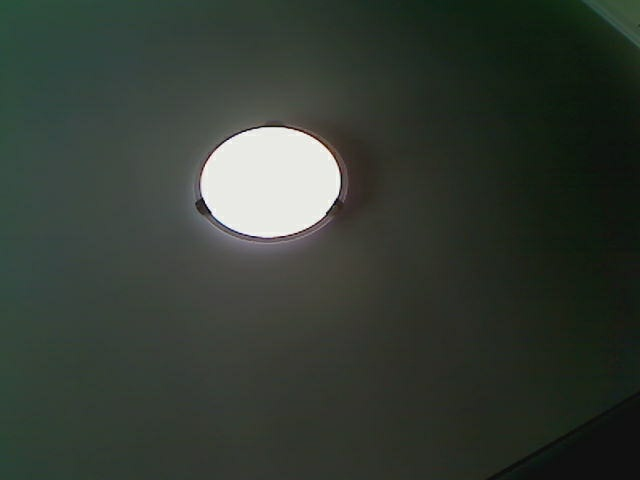

In [44]:
PIL.Image.fromarray(tf.cast(next(iter(train_ds))[0][4], tf.uint8).numpy())

In [45]:
import tensorflow.lite

saved_model = tf.lite.TFLiteConverter.from_keras_model(model).convert()
with open('../biglight_model.tflite', 'wb') as fp:
    fp.write(saved_model)

INFO:tensorflow:Assets written to: /var/folders/sg/65tk18cj6md7chv7p96s2wlw0000gn/T/tmpv9a8ch6h/assets


INFO:tensorflow:Assets written to: /var/folders/sg/65tk18cj6md7chv7p96s2wlw0000gn/T/tmpv9a8ch6h/assets


In [55]:
interpreter = tensorflow.lite.Interpreter(model_path='../biglight_model.tflite')
interpreter.allocate_tensors()
interpreter.get_input_details(), interpreter.get_output_details()

([{'name': 'rescaling_2_input',
   'index': 0,
   'shape': array([  1, 480, 640,   3], dtype=int32),
   'shape_signature': array([ -1, 480, 640,   3], dtype=int32),
   'dtype': numpy.float32,
   'quantization': (0.0, 0),
   'quantization_parameters': {'scales': array([], dtype=float32),
    'zero_points': array([], dtype=int32),
    'quantized_dimension': 0},
   'sparsity_parameters': {}}],
 [{'name': 'Identity',
   'index': 27,
   'shape': array([1, 2], dtype=int32),
   'shape_signature': array([-1,  2], dtype=int32),
   'dtype': numpy.float32,
   'quantization': (0.0, 0),
   'quantization_parameters': {'scales': array([], dtype=float32),
    'zero_points': array([], dtype=int32),
    'quantized_dimension': 0},
   'sparsity_parameters': {}}])

In [53]:
a_photo = tf.cast(next(iter(train_ds))[0][4], tf.uint8).numpy()

a_photo = np.expand_dims(a_photo, axis=0).astype('float32')
a_photo

array([[[[42., 76., 59.],
         [42., 76., 59.],
         [42., 76., 59.],
         ...,
         [57., 82., 52.],
         [57., 82., 52.],
         [58., 83., 53.]],

        [[42., 76., 59.],
         [42., 76., 59.],
         [42., 76., 59.],
         ...,
         [57., 82., 52.],
         [57., 82., 52.],
         [58., 83., 53.]],

        [[40., 77., 59.],
         [40., 77., 59.],
         [40., 78., 57.],
         ...,
         [58., 81., 53.],
         [58., 81., 53.],
         [59., 82., 54.]],

        ...,

        [[42., 62., 50.],
         [42., 62., 50.],
         [42., 62., 50.],
         ...,
         [16., 16., 16.],
         [16., 16., 16.],
         [16., 16., 16.]],

        [[44., 62., 50.],
         [44., 62., 50.],
         [44., 62., 50.],
         ...,
         [16., 16., 16.],
         [16., 16., 16.],
         [16., 16., 16.]],

        [[44., 62., 50.],
         [44., 62., 50.],
         [44., 62., 50.],
         ...,
         [16., 16., 16.],
        

In [60]:
interpreter.set_tensor(0, a_photo)
interpreter.invoke()
interpreter.get_tensor(27)[0][1]

1.0